In [1]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

# make spline

In [2]:
# p["soapfile"] = "halo_properties_0078.hdf5"
# p["simsize"] = "L2800N5040"
# p["snapshot"] = "flamingo_0078/flamingo_0078.hdf5"
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)

total nr halos in selection:  459086
nr inside mass selection:  1068630
nr with nonzero luminosity:  496983


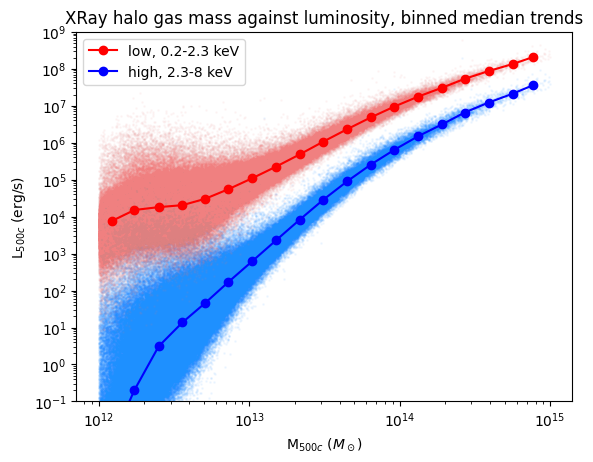

In [26]:
### get median binned mass per luminosity 
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
# luminosity_selection_low = luminosity[:,0] < 1e45
# luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero#*luminosity_selection_low*luminosity_selection_high

z = 0.05
H0 = 70 #km/s/Mpc
c = 3e5 #km/s
r = c*z/H0 * 3.08567758e22 #m
telescope_diameter = 1 #m
telescope_surface = np.pi * telescope_diameter**2 #m^2
flux_ratio = telescope_surface / (4*np.pi*r**2*(1+z)) #frac of luminosity that arrives at distance r on telescope surface
exposure_time = 100000.0 #s

mass = mass[selection]
luminosity = luminosity[selection]*flux_ratio*exposure_time
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))


plt.scatter(mass, luminosity[:, 1], s=1, c="dodgerblue", alpha=0.05)
plt.scatter(mass, luminosity[:, 0], s=1, c="lightcoral", alpha=0.05)


bins = np.logspace(12, 15, 20)

luminosities_low = []
masses_low = []
luminosities_high = []
masses_high = []
for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])

    luminosities_low.append(np.median(luminosity[indices,0]))
    masses_low.append(np.median(mass[indices]))
    
    luminosities_high.append(np.median(luminosity[indices,1]))
    masses_high.append(np.median(mass[indices]))


# print(flux_ratio)
# print(exposure_time)
# print(luminosities_high)
# plt.figure(figsize=(10, 10))
plt.plot(masses_low, luminosities_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(masses_high, luminosities_high, c="blue", marker="o", label="high, 2.3-8 keV")
plt.ylim(1e-1, 1e9)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("L$_{500c}$ (erg/s)")
plt.title("XRay halo gas mass against luminosity, binned median trends")
plt.legend()
plt.show()

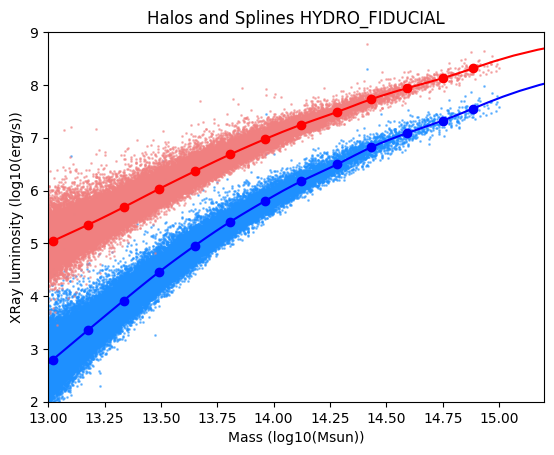

In [24]:
### get splines through these binned medians
from scipy.interpolate import CubicSpline
spl_low = CubicSpline(np.log10(luminosities_low), np.log10(masses_low), bc_type=((1, 0.79), (2, 0.0)))
spl_high = CubicSpline(np.log10(luminosities_high), np.log10(masses_high), bc_type="natural")

x = np.linspace(-2, 9, 100)
plt.plot(spl_low(x), x, c="red")
plt.plot(spl_high(x), x, c="blue")
plt.scatter(np.log10(mass), np.log10(luminosity[:, 1]), s=1, c="dodgerblue", alpha=0.5)
plt.scatter(np.log10(mass), np.log10(luminosity[:, 0]), s=1, c="lightcoral", alpha=0.5)
plt.scatter(np.log10(masses_low), np.log10(luminosities_low), c="red", label="low, 0.2-2.3 keV")
plt.scatter(np.log10(masses_high), np.log10(luminosities_high), c="blue", label="high, 2.3-8 keV")
plt.xlim(13, 15.2)
plt.ylim(2, 9)
plt.xlabel("Mass (log10(Msun))")
plt.ylabel("XRay luminosity (log10(erg/s))")
plt.title("Halos and Splines "+p["model"])
plt.savefig("/home/tol/Documents/Thesis/plots/"+"spline_"+p_to_filename(p), dpi=200)
plt.show()

In [20]:
### save splines
filename = p_to_filename(p)
np.save(p['model_path'] + filename + "_spline_fit_low", spl_low, allow_pickle=True)
np.save(p['model_path'] + filename + "_spline_fit_high", spl_high, allow_pickle=True)


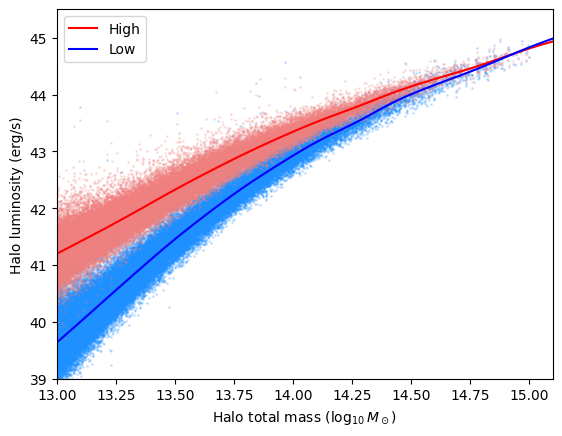

In [19]:
x = np.linspace(39, 45, 100)
filename = p_to_filename(p)
spl_low = np.load(p['model_path'] + filename + "_spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(p['model_path'] + filename + "_spline_fit_high.npy", allow_pickle=True)[()]

plt.plot(spl_low(x), x, c="red", label="High")
plt.plot(spl_high(x), x, c="blue", label="Low")

plt.scatter(np.log10(mass), np.log10(luminosity[:, 1]), s=1, c="dodgerblue", alpha=0.2)
plt.scatter(np.log10(mass), np.log10(luminosity[:, 0]), s=1, c="lightcoral", alpha=0.2)
# plt.scatter(np.log10(luminosities_low), np.log10(masses_low), c="red", alpha=0.5)
# plt.scatter(np.log10(luminosities_high), np.log10(masses_high), c="blue", alpha=0.5)
plt.xlim(13, 15.1)
plt.ylim(39, 45.5)
plt.xlabel(r"Halo total mass $(\log_{10}M_\odot)$")
plt.ylabel("Halo luminosity (erg/s)")
plt.legend()
plt.savefig("scaling relation fig", dpi=200)
plt.show()



# 2d spline

In [7]:
from scipy.interpolate import CloughTocher2DInterpolator
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayLuminosityWithoutRecentAGNHeating"][:]
luminosity_selection_low = luminosity[:,0] < 1e45
luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero*luminosity_selection_low*luminosity_selection_high

mass = mass[selection]
luminosity = luminosity[selection]

In [81]:
x = np.log10(luminosity[:,0])
y = np.log10(luminosity[:,1])
z = np.log10(mass)
interp = CloughTocher2DInterpolator(list(zip(x, y)), z, tol=1e4)

In [54]:
# filename = p_to_filename(p)
# np.save(p['model_path'] + filename + "_scalingrelation", interp, allow_pickle=True)

In [56]:
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), 500), np.linspace(np.min(y), np.max(y), 500))
Z = interp(X, Y)

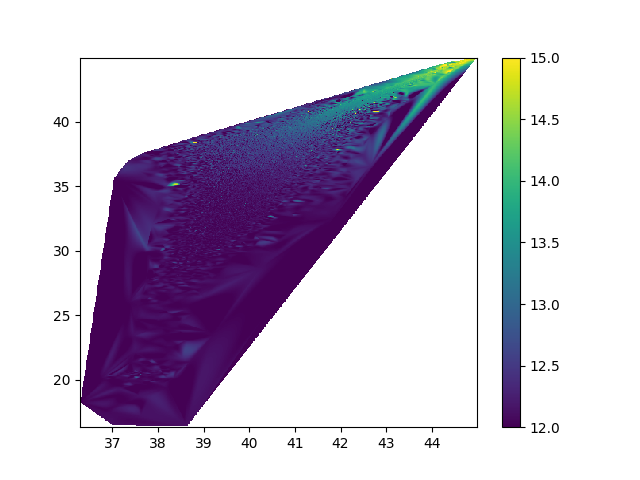

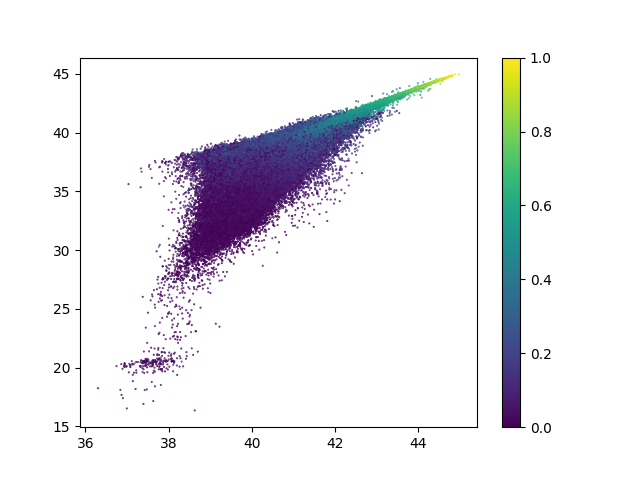

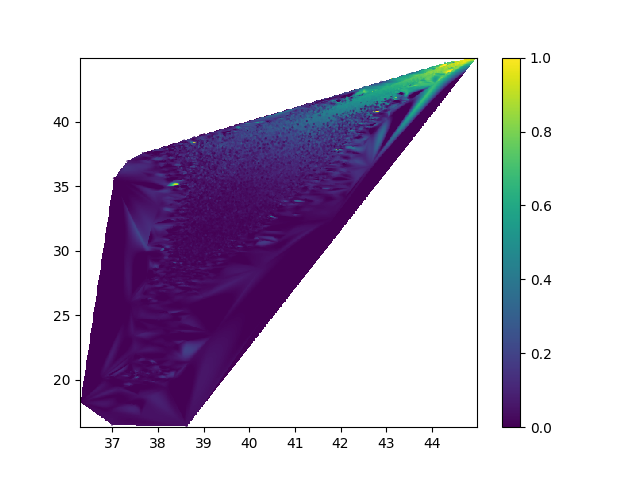

In [57]:
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.colorbar()
plt.show()
plt.figure()
plt.scatter(x, y, s=0.2, c=plt.cm.viridis((z - np.min(z))/np.max((z - np.min(z)))))
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.scatter(x, y, s=0.2, c=plt.cm.viridis((z - np.min(z))/np.max((z - np.min(z)))))
plt.colorbar()
plt.show()

In [87]:
### Hieronder voor zelf gemaakte binned grid

In [106]:
binsize = 0.2
binX = np.arange(np.min(x), np.max(x), binsize)
binY = np.arange(np.min(y), np.max(y), binsize)
mediangrid = np.empty((len(binX), len(binY)))
pointsX = []
pointsY = []
pointsZ = []
for i in range(len(binX)-1):
    for j in range(len(binY)-1):
        selectionX = np.logical_and(x > binX[i], x < binX[i+1])
        selectionY = np.logical_and(y > binY[j], y < binY[j+1])
        indices = np.logical_and(selectionX, selectionY)

        if np.sum(indices)>0:
            pointsX.append((binX[i]+binX[i+1])/2)
            pointsY.append((binY[j]+binY[j+1])/2)
            pointsZ.append(np.median(z[indices]))

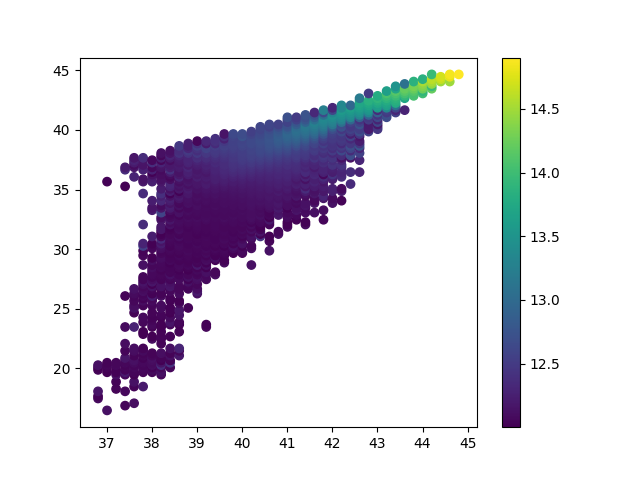

In [107]:
plt.figure()
plt.scatter(pointsX, pointsY, c=pointsZ)
plt.colorbar()
plt.show()

In [108]:
interp = CloughTocher2DInterpolator(list(zip(pointsX, pointsY)), pointsZ)
Z = interp(X, Y)

In [109]:
print(pointsZ)

[12.069917, 12.016326, 12.157356, 12.035221, 12.005872, 12.117971, 12.118681, 12.007709, 12.03285, 12.050431, 12.027849, 12.023011, 12.028723, 12.013623, 12.115833, 12.014035, 12.017672, 12.062712, 12.057841, 12.043737, 12.067376, 12.060284, 12.196319, 12.0441, 12.055211, 12.025978, 12.065917, 12.047934, 12.166986, 12.037793, 12.099828, 12.087042, 12.0309, 12.010903, 12.343923, 12.197034, 12.112967, 12.027411, 12.133333, 12.004027, 12.036012, 12.06286, 12.037366, 12.084944, 12.122918, 12.028723, 12.100568, 12.108505, 12.269447, 12.03436, 12.142162, 12.096853, 12.048768, 12.0420475, 12.089326, 12.129197, 12.280831, 12.177648, 12.083209, 12.210452, 12.274929, 12.161877, 12.204669, 12.025217, 12.050381, 12.06027, 12.043383, 12.061088, 12.059845, 12.012718, 12.048729, 12.026096, 12.089326, 12.034808, 12.020788, 12.011812, 12.056206, 12.064323, 12.026974, 12.099086, 12.022126, 12.059614, 12.03822, 12.113686, 12.083706, 12.051261, 12.107127, 12.153443, 12.036304, 12.047097, 12.124253, 12.050

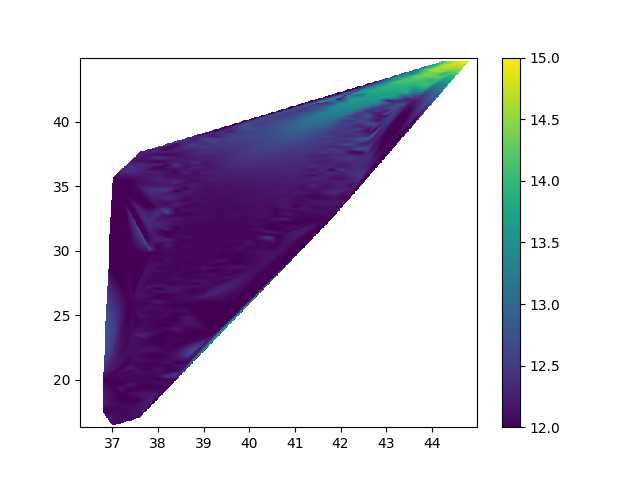

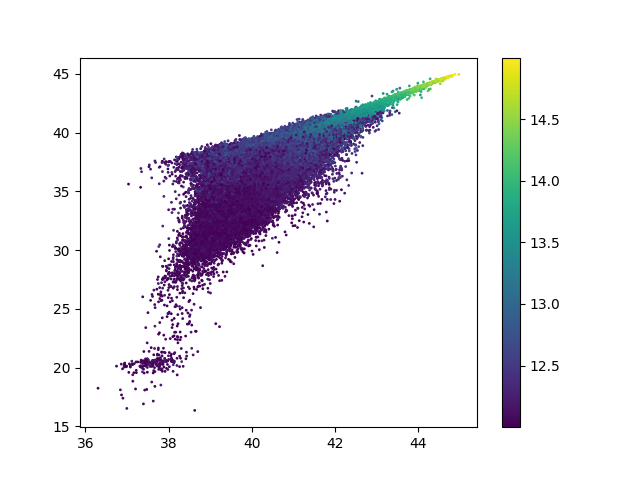

In [112]:
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.colorbar()
plt.show()
plt.figure()
plt.scatter(x, y, s=1, c=z)
plt.colorbar()
plt.show()
plt.figure()
plt.pcolormesh(X, Y, Z, shading="auto", vmin=12, vmax=15)
plt.scatter(x, y, s=1, c=z)
plt.colorbar()
plt.show()

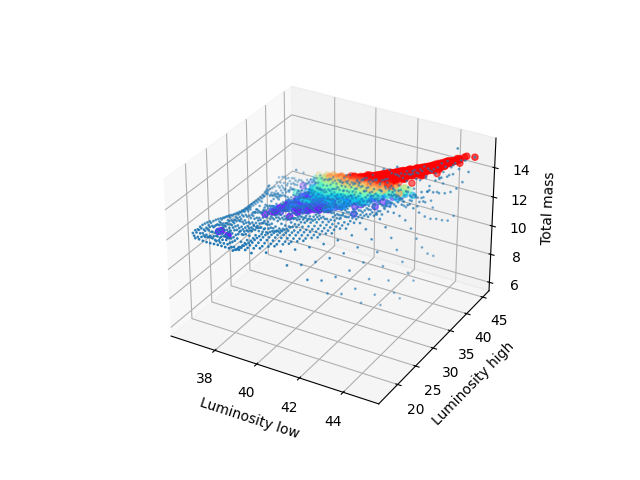

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

AttributeError: 'QuadMesh' object has no attribute 'do_3d_projection'

In [37]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X, Y, Z, s=1)
ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlabel("Total mass")

stepsize = 50
m = np.log10(mass[::stepsize])
llow = np.log10(luminosity[::stepsize,0])
lhigh = np.log10(luminosity[::stepsize,1])
ax.scatter(llow, lhigh, m, color=plt.cm.rainbow((m - np.min(m))))

plt.show()

# plot scaling relation

In [7]:
%matplotlib widget
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)

In [29]:
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayLuminosityWithoutRecentAGNHeating"][:]
luminosity_selection_low = luminosity[:,0] < 1e45
luminosity_selection_high = luminosity[:,1] < 1e45
mass_selection = np.logical_and(mass > 1e13, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero*luminosity_selection_low*luminosity_selection_high

mass = mass[selection]
luminosity = luminosity[selection]

In [6]:
print(luminosity.shape)

(459084, 3)


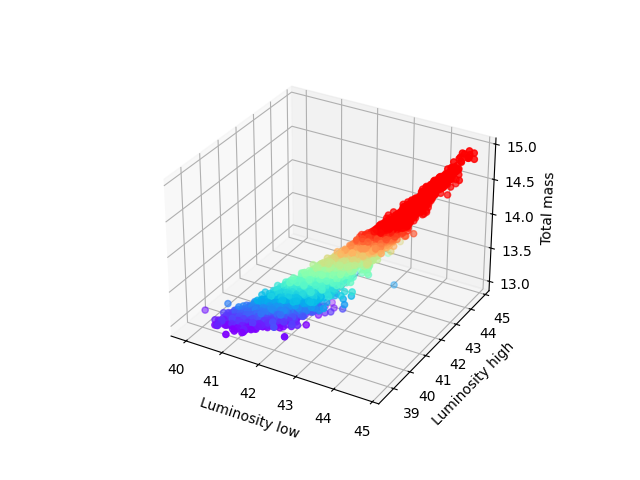

In [32]:
stepsize = 5
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
m = np.log10(mass[::stepsize])
llow = np.log10(luminosity[::stepsize,0])
lhigh = np.log10(luminosity[::stepsize,1])
ax.scatter(llow, lhigh, m, color=plt.cm.rainbow((m - np.min(m))))
ax.set_xlabel("Luminosity low")
ax.set_ylabel("Luminosity high")
ax.set_zlabel("Total mass")
plt.show()

In [345]:
# def predict_mass(l, band="low"):
#     poly = np.poly1d(np.load(f"/home/tol/Documents/Thesis/models/linear_fit_{band}_6.npy"))
#     return 10**poly(np.log10(l))

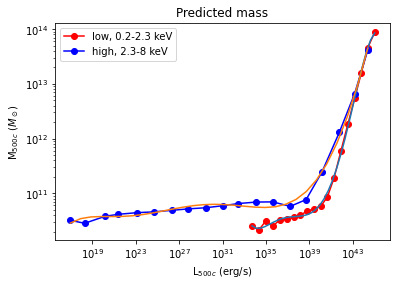

In [353]:
plt.plot(luminosities_low, gasmasses_low, c="red", marker="o", label="low, 0.2-2.3 keV")
plt.plot(luminosities_high, gasmasses_high, c="blue", marker="o", label="high, 2.3-8 keV")

testluminosities = np.logspace(np.log10(luminosities_low[0]), np.log10(luminosities_low[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="low"))

testluminosities = np.logspace(np.log10(luminosities_high[0]), np.log10(luminosities_high[-1]), 30)
plt.plot(testluminosities, predict_mass(testluminosities, band="high"))


plt.xscale("log")
plt.yscale("log")
plt.ylabel("M$_{500c}$ $(M_\odot)$")
plt.xlabel("L$_{500c}$ (erg/s)")
plt.title("Predicted mass")
plt.legend()
plt.show()